In [118]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from utils import *


Synthetic data shape:  (1000, 2) (1000,)


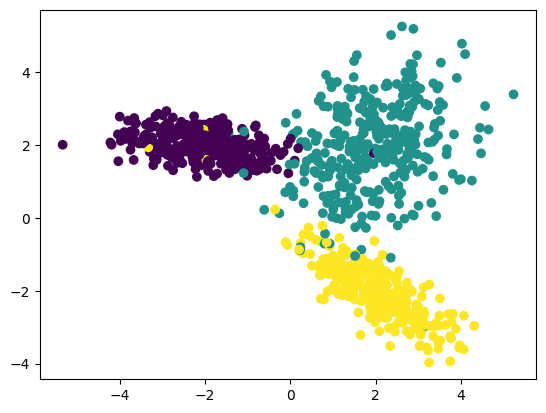

MNIST data shape:  (1000, 784) (1000,)


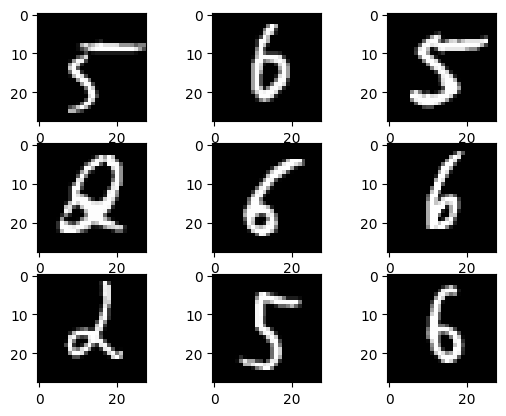

In [130]:
# Get Datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

# Plot synthetic data
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])
plt.show()

mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

# Plot MNIST data
for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28, 28), cmap='gray')
plt.show()

In [280]:
class MyLabelSelection:
    def __init__(self, ratio, num_classes):
        self.ratio = ratio  # percentage of data to label
        self.num_classes = num_classes  # number of clusters


    def select(self, trainX):
        X_normalized = normalize(trainX, axis=0)#
        kmeans = KMeans(n_clusters=self.num_classes, random_state=0).fit(X_normalized)
        labels = kmeans.labels_

        num_samples_to_label = int(trainX.shape[0] * self.ratio)
        select_point = cp.Variable(trainX.shape[0], boolean=True)
        select_cluster = cp.Variable(self.num_classes, boolean=True)

        # Objective - Maximizing the number of clusters represented
        objective = cp.Maximize(cp.sum(select_cluster))

        # Constraints
        constraints = [cp.sum(select_point) == num_samples_to_label]
        for k in range(self.num_classes):
            cluster_indices = (labels == k)
            constraints.append(select_cluster[k] <= cp.sum(select_point[cluster_indices]))

        problem = cp.Problem(objective, constraints)
        problem.solve()#solver=cp.GLPK_MI)

        selected_indices = np.where(select_point.value >= 0.5)[0]
        data_to_label = trainX[selected_indices, :]
        return data_to_label
    
    
    def randomly_select(self, trainX):
        if self.ratio == 1:
            return trainX
        num_samples_to_label = int(trainX.shape[0] * self.ratio)
        # Randomly choose indices without replacement
        selected_indices = np.random.choice(trainX.shape[0], num_samples_to_label, replace=False)
        data_ramdomly_label = trainX[selected_indices, :]
        return data_ramdomly_label
    
   

In [231]:
# Task 3 - 1 Label Selection
ratio = 1 # percentage of data to label

num_classes_syn = len(np.unique(syn_data['trainY']))
MySelector_syn = MyLabelSelection(ratio, num_classes=num_classes_syn)
L_syn = MySelector_syn.select(syn_data['trainX'])

num_classes_mnist = len(np.unique(mnist_data['trainY']))
MySelector_mnist = MyLabelSelection(ratio, num_classes=num_classes_mnist)
L_mnist = MySelector_mnist.select(mnist_data['trainX'])

#L_mnist.shape) # (500, 784)

c:\Users\dyf11\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dyf11\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\dyf11\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dyf11\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

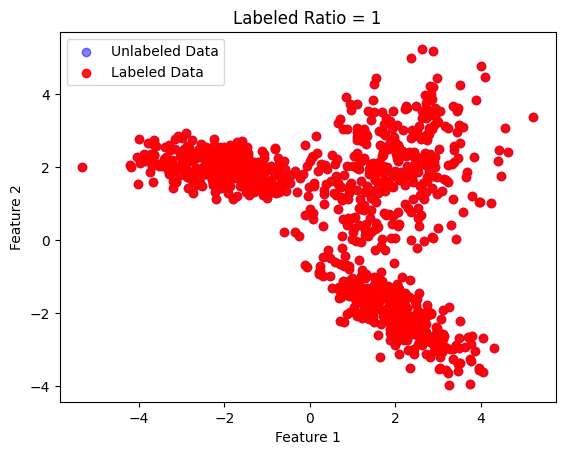

In [232]:
# Plot the labeled and unlabeled data of Synthetic Dataset
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c='blue', label='Unlabeled Data', alpha=0.5)
plt.scatter(L_syn[:, 0], L_syn[:, 1], c='red', label='Labeled Data', alpha=0.9)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Labeled Ratio = ' + str(ratio))
plt.legend()
plt.show()


In [233]:
# Train classifiers from Task 1
from MySolution import MyClassifier


# Train on labled data of synthetic dataset
classifier_synthetic_ss = MyClassifier(num_classes_syn)
classifier_synthetic_ss.train(L_syn, syn_data['trainY'])

# Train on labled data of MNIST dataset
classifier_MNIST_ss = MyClassifier(num_classes_mnist)
classifier_MNIST_ss.train(L_mnist, mnist_data['trainY'])

c:\Users\dyf11\miniconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Accuracy on synthetic test set: 0.972


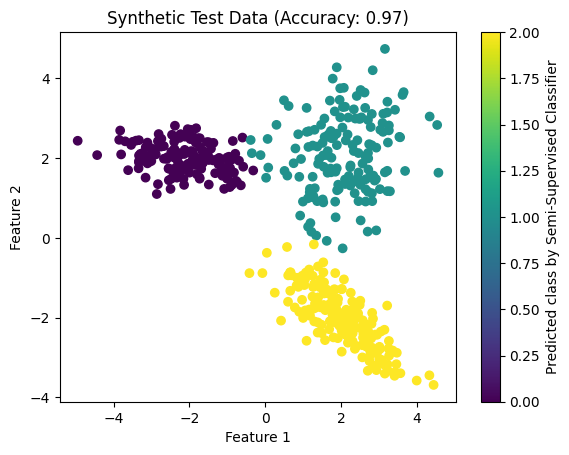

Accuracy on MNIST test set: 0.838


In [234]:
# Test the semi-supervised classifier on synthetic testset
synthetic_ss_acc = classifier_synthetic_ss.evaluate(syn_data['testX'], syn_data['testY'])
print(f"Accuracy on synthetic test set: {synthetic_ss_acc}")
if syn_data is not None and classifier_synthetic_ss is not None:
    predicted_labels_synthetic = classifier_synthetic_ss.predict(syn_data['testX'])
    plt.scatter(syn_data['testX'][:, 0], syn_data['testX'][:, 1], c=predicted_labels_synthetic)
    plt.title(f"Synthetic Test Data (Accuracy: {synthetic_ss_acc:.2f})")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Predicted class by Semi-Supervised Classifier')
    plt.show()

# Test the semi-supervised classifier on MNIST testset
mnist_ss_acc = classifier_MNIST_ss.evaluate(mnist_data['testX'], mnist_data['testY'])
print(f"Accuracy on MNIST test set: {mnist_ss_acc}")

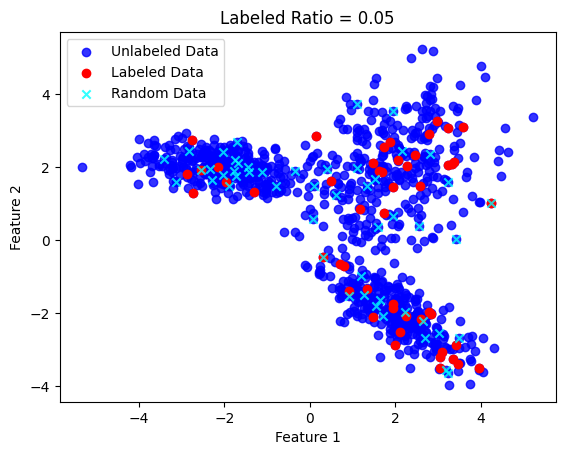

c:\Users\dyf11\miniconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)



Accuracy(random) on synthetic test set: 0.2
Accuracy(random) on MNIST test set: 0.246


In [227]:
# Ramdomly labele data, traning and testing

L_syn_rd = MySelector_syn.randomly_select(syn_data['trainX'])
L_mnist_rd = MySelector_mnist.randomly_select(mnist_data['trainX'])

# Plot the LP labeled, random labeled, and unlabeled data of Synthetic Dataset
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c='blue', label='Unlabeled Data', alpha=0.8)
plt.scatter(L_syn[:, 0], L_syn[:, 1], c='red', label='Labeled Data')
plt.scatter(L_syn_rd[:, 0], L_syn_rd[:, 1], c='cyan', label='Random Data', alpha=0.8, marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Labeled Ratio = ' + str(ratio))
plt.legend()
plt.show()

# Train on randomly labled data of synthetic and NMIST dataset
classifier_synthetic_rd = MyClassifier(num_classes_syn)
classifier_synthetic_rd.train(L_syn_rd, syn_data['trainY'])

classifier_MNIST_rd = MyClassifier(num_classes_mnist)
classifier_MNIST_rd.train(L_mnist_rd, mnist_data['trainY'])

# Test the classifiers testsets
synthetic_rd_acc = classifier_synthetic_rd.evaluate(syn_data['testX'], syn_data['testY'])
nmist_rd_acc = classifier_MNIST_rd.evaluate(mnist_data['testX'], mnist_data['testY'])
print(f"\nAccuracy(random) on synthetic test set: {synthetic_rd_acc}")
print(f"Accuracy(random) on MNIST test set: {nmist_rd_acc}")

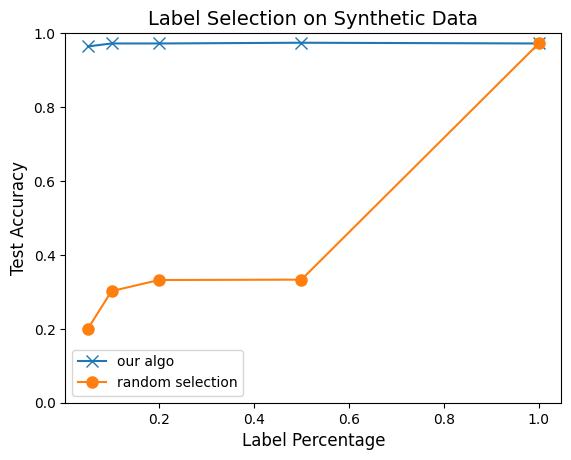

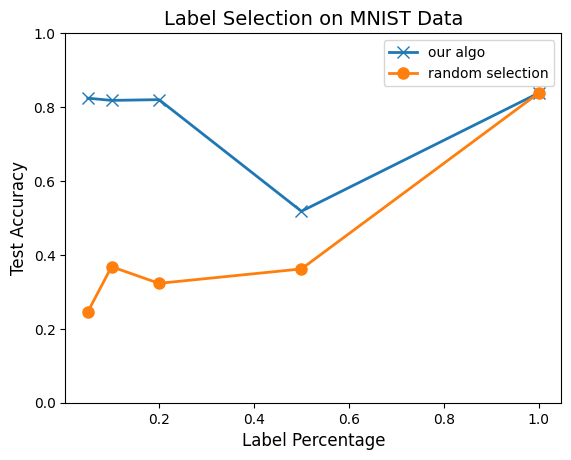

In [235]:
result3 = {
    "synthetic": {
        "label_percentage":[0.05,0.1,0.2,0.5,1.0],
        "test_accuracy(our algo)":[0.964,0.972,0.972,0.974,0.972],
        'test_accuracy(random)':[0.2,0.302,0.332,0.333,0.972]
    },
    "mnist": {
        "label_percentage":[0.05,0.1,0.2,0.5,1.0],
        "test_accuracy(our algo)":[0.824,0.818,0.82,0.518,0.838],
        'test_accuracy(random)':[0.246,0.368,0.323,0.362,0.838]
    } 
}
plot_result(result3 = result3)

## For Task4 Simulation, we adding Gassin Noise as an instance to increase the number of samples

Synthetic data shape:  (1000, 2) (1000,)
The shape of the dataset after adding gassian noise:  (1500, 2) (1500,)


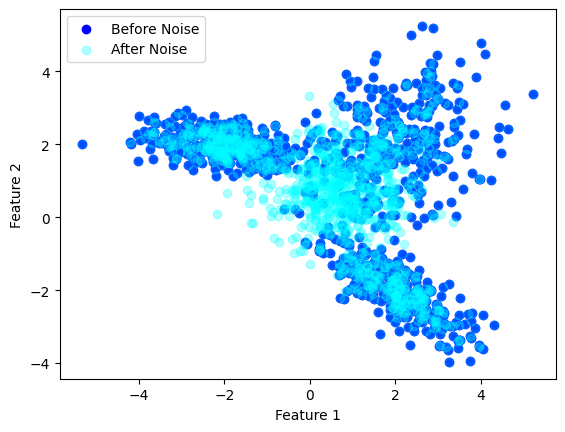

In [277]:
def generate_new_data_points(trainX, trainY, num_points):
    # Adding Gaussian noise to Features
    means = trainX.mean(axis=0)
    stds = trainY.std(axis=0)
    new_points = np.random.randn(num_points, trainX.shape[1]) * stds + means
    new_trainX = np.vstack((trainX, new_points))
    # Adding Gaussian noise to Labels
    new_trainY = np.hstack((trainY, np.random.choice([0, 1, 2], size = num_points)))
    print("The shape of the dataset after adding gassian noise: ", new_trainX.shape, new_trainY.shape)
    return new_trainX, new_trainY

# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

# Generate new data points for synthetic dataset
trainX_new, trainY_new = generate_new_data_points(syn_data['trainX'], syn_data['trainY'], 500)

# Plot the data of Synthetic Dataset
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c='blue', label='Before Noise', alpha=1)
plt.scatter(trainX_new[:, 0], trainX_new[:, 1], c='cyan', label='After Noise', alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


c:\Users\dyf11\miniconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Accuracy on synthetic test set: 0.966


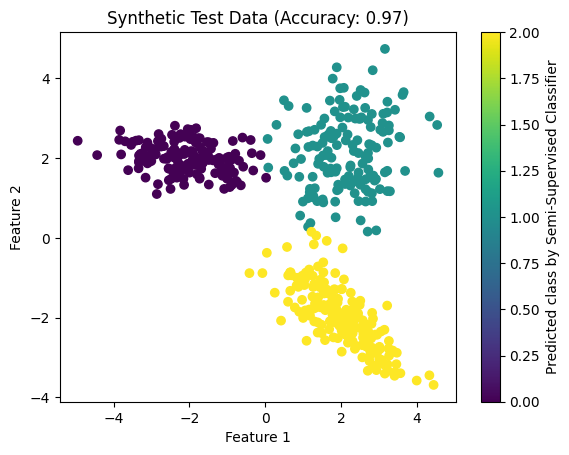

In [278]:
# Task 1 after noise
# Initialize classifier
num_classes_synthetic = len(np.unique(syn_data['trainY'])) 
classifier_synthetic = MyClassifier(num_classes_synthetic)
classifier_synthetic.train(trainX_new, trainY_new)
new_syn_acc = classifier_synthetic.evaluate(syn_data['testX'], syn_data['testY'])
print(f"Accuracy on synthetic test set: {new_syn_acc}")
if syn_data is not None and classifier_synthetic_ss is not None:
    predicted_labels_synthetic = classifier_synthetic_ss.predict(syn_data['testX'])
    plt.scatter(syn_data['testX'][:, 0], syn_data['testX'][:, 1], c=predicted_labels_synthetic)
    plt.title(f"Synthetic Test Data (Accuracy: {new_syn_acc:.2f})")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Predicted class by Semi-Supervised Classifier')
    plt.show()

c:\Users\dyf11\miniconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Accuracy on synthetic test set: 0.966


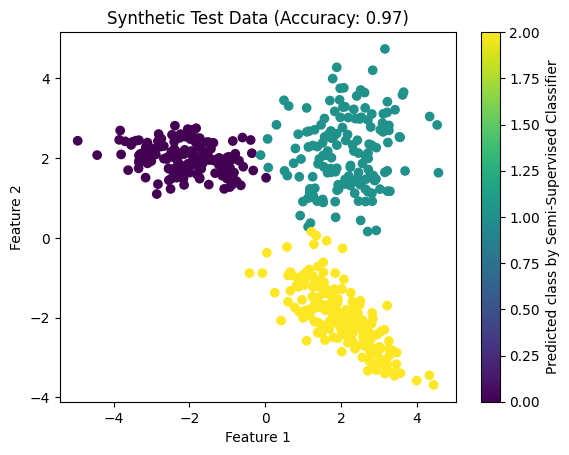

In [279]:
# Task 3 after noise
classifier_synthetic_ss.train(trainX_new, trainY_new)
new_syn_ss_acc = classifier_synthetic_ss.evaluate(syn_data['testX'], syn_data['testY'])
print(f"Accuracy on synthetic test set: {new_syn_ss_acc}")
if syn_data is not None and classifier_synthetic_ss is not None:
    predicted_labels_synthetic = classifier_synthetic_ss.predict(syn_data['testX'])
    plt.scatter(syn_data['testX'][:, 0], syn_data['testX'][:, 1], c=predicted_labels_synthetic)
    plt.title(f"Synthetic Test Data (Accuracy: {new_syn_ss_acc:.2f})")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Predicted class by Semi-Supervised Classifier')
    plt.show()